In [1]:
# test_gpu.py
import torch, sys
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda version (torch build):", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA device visible to PyTorch.")

torch: 2.9.1+cu128
cuda available: True
cuda version (torch build): 12.8
GPU count: 1
Current device: 0
Device name: NVIDIA RTX A6000


In [8]:
!pip install timm -q
!pip install seaborn
!pip install tqdm -q

In [2]:
import os
from pathlib import Path
import random
import numpy as np

import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Updated paths for your local DFF folder
DATA_ROOT = Path(r"c:\Users\akshay-stu\Desktop\Deep Fake Detection\DFF")
OUT_ROOT  = Path(r"c:\Users\akshay-stu\Desktop\Deep Fake Detection\dfd_faces")

# Your dataset subfolders:
MANIPULATED_DIR = DATA_ROOT / "DFD_manipulated_sequences" / "DFD_manipulated_sequences"
ORIGINAL_DIR    = DATA_ROOT / "DFD_original sequences"

NUM_FRAMES = 16
IMG_SIZE   = 224
BATCH_SIZE = 4
EPOCHS     = 25
LR         = 1e-4
SEED       = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Verify paths exist
print(f"DATA_ROOT exists: {DATA_ROOT.exists()}")
print(f"Manipulated folder exists: {MANIPULATED_DIR.exists()}")
print(f"Original folder exists: {ORIGINAL_DIR.exists()}")

Using: cuda
DATA_ROOT exists: True
Manipulated folder exists: True
Original folder exists: True


In [3]:
real_dir = DATA_ROOT / "DFD_original sequences"
fake_dir = DATA_ROOT / "DFD_manipulated_sequences" / "DFD_manipulated_sequences"

real_videos = sorted([p for p in real_dir.glob("*.mp4")])
fake_videos = sorted([p for p in fake_dir.glob("*.mp4")])[:400]

print("Num real:", len(real_videos))
print("Num fake:", len(fake_videos))

# Debug: If counts are 0, check what files exist
if len(real_videos) == 0:
    print("No .mp4 files found in real_dir. Contents:", list(real_dir.iterdir())[:5] if real_dir.exists() else "Directory doesn't exist")
if len(fake_videos) == 0:
    print("No .mp4 files found in fake_dir. Contents:", list(fake_dir.iterdir())[:5] if fake_dir.exists() else "Directory doesn't exist")

all_paths = real_videos + fake_videos
all_labels = [1]*len(real_videos) + [0]*len(fake_videos)   # 1: real, 0: fake

train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_paths, all_labels, test_size=0.2, random_state=SEED, stratify=all_labels
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=SEED, stratify=train_labels
)

def build_split_list(paths, labels):
    return [{"path": p, "label": int(l)} for p, l in zip(paths, labels)]

splits = {
    "train": build_split_list(train_paths, train_labels),
    "val":   build_split_list(val_paths,   val_labels),
    "test":  build_split_list(test_paths,  test_labels),
}

for k, v in splits.items():
    print(k, len(v))

Num real: 363
Num fake: 400
train 488
val 122
test 153


In [4]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

def center_crop_resize(img, size=224):
    h, w = img.shape[:2]
    side = min(h, w)
    cx, cy = w // 2, h // 2
    x1 = max(0, cx - side // 2)
    y1 = max(0, cy - side // 2)
    crop = img[y1:y1+side, x1:x1+side]
    return cv2.resize(crop, (size, size))

def detect_face_crop(img, size=224):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3,
                                          minNeighbors=5, minSize=(60, 60))
    if len(faces) == 0:
        return center_crop_resize(img, size), False

    x, y, w, h = max(faces, key=lambda b: b[2]*b[3])
    x1, y1, x2, y2 = x, y, x+w, y+h
    face = img[y1:y2, x1:x2]
    face = cv2.resize(face, (size, size))
    return face, True

def extract_faces_from_video(video_path: Path, out_dir: Path,
                             num_frames=16, img_size=224):
    out_dir.mkdir(parents=True, exist_ok=True)
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print("Cannot open:", video_path)
        return 0

    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        print("No frames:", video_path)
        cap.release()
        return 0

    indices = np.linspace(0, total-1, num_frames, dtype=int)

    saved = 0
    for i, idx in enumerate(indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame = cap.read()
        if not ok or frame is None:
            continue
        face, _ = detect_face_crop(frame, size=img_size)
        out_path = out_dir / f"{i:03d}.jpg"
        cv2.imwrite(str(out_path), face)
        saved += 1

    cap.release()
    return saved

In [5]:
from tqdm import tqdm

def get_class_name(label_int):
    return "real" if label_int == 1 else "fake"

for split_name, items in splits.items():
    print(f"\n{'='*50}")
    print(f"Processing {split_name} ({len(items)} videos)...")
    print('='*50)
    
    for info in tqdm(items, desc=split_name, unit="video"):
        vpath = info["path"]
        label = info["label"]
        cls_name = get_class_name(label)

        video_id = vpath.stem  
        out_dir = OUT_ROOT / split_name / cls_name / video_id

        if out_dir.exists():
            continue

        n_saved = extract_faces_from_video(vpath, out_dir,
                                           num_frames=NUM_FRAMES,
                                           img_size=IMG_SIZE)
        if n_saved == 0:
            if out_dir.exists():
                for f in out_dir.glob("*.jpg"):
                    f.unlink()
                out_dir.rmdir()

print("\n" + "="*50)
print("Preprocessing finished!")
print(f"Output folder: {OUT_ROOT}")
print("="*50)


Processing train (488 videos)...


train: 100%|██████████████████████████████████████████████████████████████████████| 488/488 [16:10<00:00,  1.99s/video]



Processing val (122 videos)...


val: 100%|████████████████████████████████████████████████████████████████████████| 122/122 [04:12<00:00,  2.07s/video]



Processing test (153 videos)...


test: 100%|███████████████████████████████████████████████████████████████████████| 153/153 [05:00<00:00,  1.96s/video]


Preprocessing finished!
Output folder: c:\Users\akshay-stu\Desktop\Deep Fake Detection\dfd_faces


In [11]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import numpy as np
import torch

class VideoFaceDataset(Dataset):
    def __init__(self, root, num_frames=16, img_size=224):
        self.root = Path(root)
        self.num_frames = num_frames

        self.classes = ["fake", "real"]
        self.class_to_idx = {"fake": 0, "real": 1}

        self.samples = []
        for cls in self.classes:
            cdir = self.root / cls
            if not cdir.exists():
                continue
            for video_dir in sorted(cdir.iterdir()):
                if video_dir.is_dir():
                    frames = sorted(video_dir.glob("*.jpg"))
                    if len(frames) == 0:
                        continue
                    self.samples.append((video_dir, self.class_to_idx[cls]))

        print(f"Dataset @ {root}: {len(self.samples)} clips")

        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225])
        ])

    def __len__(self):
        return len(self.samples)

    def _sample_frames(self, frame_paths):
        n = len(frame_paths)
        if n >= self.num_frames:
            idx = np.linspace(0, n-1, self.num_frames, dtype=int)
        else:
            idx = list(range(n)) + [n-1]*(self.num_frames-n)
        return [frame_paths[i] for i in idx]

    def __getitem__(self, idx):
        video_dir, label = self.samples[idx]
        frames = sorted(video_dir.glob("*.jpg"))
        frames = self._sample_frames(frames)

        imgs = []
        for p in frames:
            img = Image.open(p).convert("RGB")
            img = self.transform(img)
            imgs.append(img)

        frames_tensor = torch.stack(imgs, dim=0)  # (T,C,H,W)
        return frames_tensor, torch.tensor(label, dtype=torch.long)

FACE_ROOT = OUT_ROOT   

NUM_FRAMES = 16
IMG_SIZE   = 224
BATCH_SIZE = 8

train_img_ds = VideoFaceDataset(FACE_ROOT / "train", NUM_FRAMES, IMG_SIZE)
val_img_ds   = VideoFaceDataset(FACE_ROOT / "val",   NUM_FRAMES, IMG_SIZE)
test_img_ds  = VideoFaceDataset(FACE_ROOT / "test",  NUM_FRAMES, IMG_SIZE)

# Changed num_workers=0 to fix Windows multiprocessing issue
train_img_loader = DataLoader(train_img_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=True)
val_img_loader   = DataLoader(val_img_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=True)
test_img_loader  = DataLoader(test_img_ds,  batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=True)

Dataset @ c:\Users\akshay-stu\Desktop\Deep Fake Detection\dfd_faces\train: 488 clips
Dataset @ c:\Users\akshay-stu\Desktop\Deep Fake Detection\dfd_faces\val: 122 clips
Dataset @ c:\Users\akshay-stu\Desktop\Deep Fake Detection\dfd_faces\test: 153 clips


In [12]:
import timm
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

def get_effnet_extractor(model_name="tf_efficientnet_b0_ns"):
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=0,   
        global_pool="avg"
    )
    model.eval()
    for p in model.parameters():
        p.requires_grad_(False)
    return model

effnet = get_effnet_extractor().to(device)
FEATURE_DIM = effnet.num_features
print("Feature dim:", FEATURE_DIM)

Using: cuda
Feature dim: 1280


In [13]:
from tqdm import tqdm

@torch.no_grad()
def extract_features_split(loader, save_path):
    all_feats = []
    all_labels = []

    for frames, labels in tqdm(loader, desc=f"Extracting -> {save_path.name}"):
        B, T, C, H, W = frames.shape
        frames = frames.to(device)

        frames_flat = frames.view(B*T, C, H, W)    # (B*T,C,H,W)
        feats_flat = effnet(frames_flat)           # (B*T,F)
        feats = feats_flat.view(B, T, -1)          # (B,T,F)

        all_feats.append(feats.cpu())
        all_labels.append(labels.clone())

    X = torch.cat(all_feats, dim=0)   # (N,T,F)
    y = torch.cat(all_labels, dim=0)  # (N,)
    torch.save({"features": X, "labels": y}, save_path)
    print(f"Saved {save_path}: X={X.shape}, y={y.shape}")

# Updated path for your local machine
SAVE_ROOT = Path(r"c:\Users\akshay-stu\Desktop\Deep Fake Detection\dfd_effnet_features")
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

extract_features_split(train_img_loader, SAVE_ROOT / "train_features.pt")
extract_features_split(val_img_loader,   SAVE_ROOT / "val_features.pt")
extract_features_split(test_img_loader,  SAVE_ROOT / "test_features.pt")

Extracting -> train_features.pt: 100%|█████████████████████████████████████████████████| 61/61 [00:18<00:00,  3.26it/s]


Saved c:\Users\akshay-stu\Desktop\Deep Fake Detection\dfd_effnet_features\train_features.pt: X=torch.Size([488, 16, 1280]), y=torch.Size([488])


Extracting -> val_features.pt: 100%|███████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.60it/s]


Saved c:\Users\akshay-stu\Desktop\Deep Fake Detection\dfd_effnet_features\val_features.pt: X=torch.Size([122, 16, 1280]), y=torch.Size([122])


Extracting -> test_features.pt: 100%|██████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]

Saved c:\Users\akshay-stu\Desktop\Deep Fake Detection\dfd_effnet_features\test_features.pt: X=torch.Size([153, 16, 1280]), y=torch.Size([153])


In [14]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        data = torch.load(path)
        self.X = data["features"]  # (N,T,F)
        self.y = data["labels"]    # (N,)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_feat_ds = FeatureDataset(SAVE_ROOT / "train_features.pt")
val_feat_ds   = FeatureDataset(SAVE_ROOT / "val_features.pt")
test_feat_ds  = FeatureDataset(SAVE_ROOT / "test_features.pt")

train_feat_loader = DataLoader(train_feat_ds, batch_size=64, shuffle=True)
val_feat_loader   = DataLoader(val_feat_ds,   batch_size=64, shuffle=False)
test_feat_loader  = DataLoader(test_feat_ds,  batch_size=64, shuffle=False)

print("Train features:", train_feat_ds.X.shape)

Train features: torch.Size([488, 16, 1280])


In [15]:
import math
import torch.nn.functional as F

class TemporalViT(nn.Module):
    def __init__(self,
                 feature_dim=FEATURE_DIM,
                 d_model=256,
                 n_heads=4,
                 num_layers=4,
                 num_classes=2,
                 dropout=0.1,
                 max_len=64):
        super().__init__()

        self.proj = nn.Linear(feature_dim, d_model)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.zeros(1, max_len+1, d_model))  # +1 cho CLS

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # x: (B,T,F)
        B, T, Fd = x.shape
        x = self.proj(x)                   # (B,T,d_model)

        cls = self.cls_token.expand(B, -1, -1)  # (B,1,d_model)
        x = torch.cat([cls, x], dim=1)          # (B,T+1,d_model)

        x = x + self.pos_embed[:, :T+1, :]      # add positional encoding

        h = self.encoder(x)                     # (B,T+1,d_model)
        cls_out = h[:, 0]                     
        cls_out = self.norm(cls_out)
        logits = self.fc(cls_out)
        return logits

num_classes = 2
vit_model = TemporalViT(
    feature_dim=FEATURE_DIM,
    d_model=256,
    n_heads=4,
    num_layers=4,
    num_classes=num_classes,
    max_len=NUM_FRAMES
).to(device)

print(vit_model)

TemporalViT(
  (proj): Linear(in_features=1280, out_features=256, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [16]:
def get_class_weights_from_feat_ds(dataset):
    labels = dataset.y
    counts = torch.bincount(labels, minlength=num_classes).float()
    weights = counts.sum() / (counts * len(counts) + 1e-8)
    return weights

class_weights = get_class_weights_from_feat_ds(train_feat_ds).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

def train_epoch():
    vit_model.train()
    total_loss, correct, total = 0., 0, 0
    for X, y in train_feat_loader:
        X, y = X.to(device), y.to(device)   # X: (B,T,F)
        logits = vit_model(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return total_loss/len(train_feat_loader), correct/total

@torch.no_grad()
def eval_epoch(loader):
    vit_model.eval()
    total_loss, correct, total = 0., 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = vit_model(X)
        loss = criterion(logits, y)
        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return total_loss/len(loader), correct/total

EPOCHS = 60
best_val = 0.0
# Updated path for your local machine
best_path = r"c:\Users\akshay-stu\Desktop\Deep Fake Detection\best_temporal_vit.pth"

hist = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch()
    val_loss, val_acc = eval_epoch(val_feat_loader)
    scheduler.step()

    hist["train_loss"].append(tr_loss)
    hist["val_loss"].append(val_loss)
    hist["train_acc"].append(tr_acc)
    hist["val_acc"].append(val_acc)

    if val_acc > best_val:
        best_val = val_acc
        torch.save(vit_model.state_dict(), best_path)
        print(f"[Epoch {ep:02d}] New best val_acc={val_acc*100:.2f}%, saved!")

    print(f"Epoch {ep:02d} | "
          f"Train {tr_loss:.4f}/{tr_acc*100:.2f}% | "
          f"Val {val_loss:.4f}/{val_acc*100:.2f}%")

print("Best Val Acc:", best_val*100)

Class weights: tensor([0.9531, 1.0517], device='cuda:0')
[Epoch 01] New best val_acc=79.51%, saved!
Epoch 01 | Train 0.5615/71.31% | Val 0.4830/79.51%
[Epoch 02] New best val_acc=85.25%, saved!
Epoch 02 | Train 0.3573/85.25% | Val 0.3274/85.25%
[Epoch 03] New best val_acc=88.52%, saved!
Epoch 03 | Train 0.2826/88.52% | Val 0.2963/88.52%
Epoch 04 | Train 0.2322/90.16% | Val 0.2804/86.89%
Epoch 05 | Train 0.2033/92.83% | Val 0.2735/88.52%
[Epoch 06] New best val_acc=90.16%, saved!
Epoch 06 | Train 0.1570/94.06% | Val 0.2669/90.16%
[Epoch 07] New best val_acc=93.44%, saved!
Epoch 07 | Train 0.1693/93.44% | Val 0.2124/93.44%
[Epoch 08] New best val_acc=94.26%, saved!
Epoch 08 | Train 0.1348/95.29% | Val 0.2132/94.26%
Epoch 09 | Train 0.1020/96.93% | Val 0.1937/94.26%
Epoch 10 | Train 0.1051/96.11% | Val 0.2155/94.26%
Epoch 11 | Train 0.0962/96.11% | Val 0.2226/94.26%
Epoch 12 | Train 0.1003/95.70% | Val 0.2223/92.62%
Epoch 13 | Train 0.1118/95.49% | Val 0.2027/94.26%
[Epoch 14] New best va

In [17]:
# Load the best model
vit_model.load_state_dict(torch.load(best_path))
vit_model.eval()

# Evaluate on test set
@torch.no_grad()
def get_predictions(loader):
    all_preds = []
    all_labels = []
    all_probs = []
    
    for X, y in loader:
        X = X.to(device)
        logits = vit_model(X)
        probs = torch.softmax(logits, dim=1)
        preds = logits.argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())
        all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

test_preds, test_labels, test_probs = get_predictions(test_feat_loader)
test_acc = accuracy_score(test_labels, test_preds)

print("="*50)
print(f"TEST SET RESULTS")
print("="*50)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Samples: {len(test_labels)}")

TEST SET RESULTS
Test Accuracy: 97.39%
Test Samples: 153


In [18]:
# Detailed classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(test_labels, test_preds, target_names=["Fake", "Real"]))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Fake       0.96      0.99      0.98        80
        Real       0.99      0.96      0.97        73

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



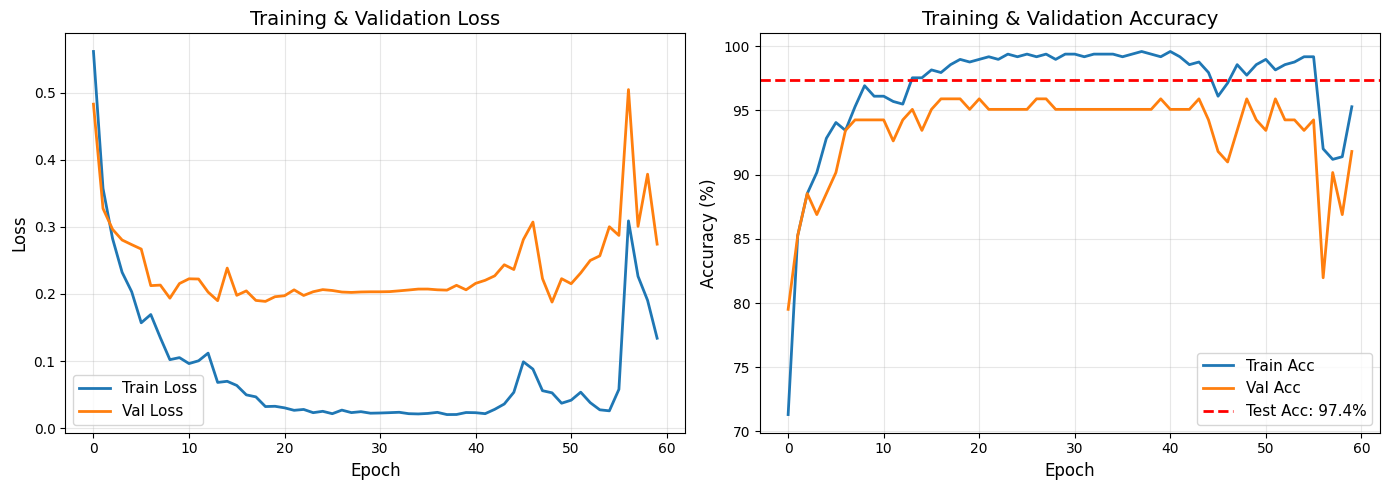

Training curves saved to: training_curves.png


In [19]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(hist["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(hist["val_loss"], label="Val Loss", linewidth=2)
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Training & Validation Loss", fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot([a*100 for a in hist["train_acc"]], label="Train Acc", linewidth=2)
axes[1].plot([a*100 for a in hist["val_acc"]], label="Val Acc", linewidth=2)
axes[1].axhline(y=test_acc*100, color='r', linestyle='--', label=f'Test Acc: {test_acc*100:.1f}%', linewidth=2)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Accuracy (%)", fontsize=12)
axes[1].set_title("Training & Validation Accuracy", fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r"c:\Users\akshay-stu\Desktop\Deep Fake Detection\training_curves.png", dpi=150)
plt.show()

print(f"Training curves saved to: training_curves.png")

In [26]:
def predict_video(video_path, threshold=0.5):
    """
    Predict if a video is real or fake.
    
    Args:
        video_path: Path to the video file
        threshold: Confidence threshold (default 0.5)
    
    Returns:
        prediction: "Real" or "Fake"
        confidence: Probability score
    """
    import tempfile
    import torchvision.transforms as transforms  # Use different name to avoid conflict
    
    video_path = Path(video_path)
    
    # Create temporary directory for frames
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_dir = Path(temp_dir)
        
        # Extract faces from video
        n_saved = extract_faces_from_video(video_path, temp_dir, 
                                           num_frames=NUM_FRAMES, img_size=IMG_SIZE)
        
        if n_saved == 0:
            return "Error: Could not extract faces", 0.0
        
        # Load and transform frames
        frames = sorted(temp_dir.glob("*.jpg"))
        
        transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
        imgs = []
        for p in frames:
            img = Image.open(p).convert("RGB")
            img = transform(img)
            imgs.append(img)
        
        # Pad if necessary
        while len(imgs) < NUM_FRAMES:
            imgs.append(imgs[-1])
        
        frames_tensor = torch.stack(imgs[:NUM_FRAMES], dim=0)  # (T, C, H, W)
        frames_tensor = frames_tensor.unsqueeze(0).to(device)  # (1, T, C, H, W)
        
        # Extract features with EfficientNet
        effnet.eval()
        with torch.no_grad():
            B, num_frames, C, H, W = frames_tensor.shape  # Renamed T to num_frames
            frames_flat = frames_tensor.view(B * num_frames, C, H, W)
            feats_flat = effnet(frames_flat)
            feats = feats_flat.view(B, num_frames, -1)  # (1, T, F)
        
        # Predict with ViT
        vit_model.eval()
        with torch.no_grad():
            logits = vit_model(feats)
            probs = torch.softmax(logits, dim=1)
            pred_class = logits.argmax(1).item()
            confidence = probs[0, pred_class].item()
        
        prediction = "Real" if pred_class == 1 else "Fake"
        
        return prediction, confidence

In [30]:
# Test multiple videos
videos_to_test = [
    r"c:\Users\akshay-stu\Desktop\Deep Fake Detection\Putin_fake.mp4",
    r"C:\Users\akshay-stu\Desktop\Deep Fake Detection\putin_walk_real.mp4",
    r"C:\Users\akshay-stu\Desktop\Deep Fake Detection\tom_fake.mp4",
    r"C:\Users\akshay-stu\Desktop\Deep Fake Detection\tom_fall_fake.mp4"
]

for v in videos_to_test:
    result, conf = predict_video(v)
    print(f"{Path(v).name}: {result} ({conf*100:.1f}%)")

Putin_fake.mp4: Fake (86.8%)
putin_walk_real.mp4: Real (99.9%)
tom_fake.mp4: Real (99.9%)
tom_fall_fake.mp4: Real (100.0%)


In [23]:
# Test the inference on a sample video from your dataset
sample_real = real_videos[0]  # First real video
sample_fake = fake_videos[0]  # First fake video

print("Testing inference on sample videos...")
print("="*50)

# Test on real video
result, conf = predict_video(sample_real)
print(f"Real Video: {sample_real.name}")
print(f"  → Prediction: {result} (Confidence: {conf*100:.1f}%)")

print()

# Test on fake video
result, conf = predict_video(sample_fake)
print(f"Fake Video: {sample_fake.name}")
print(f"  → Prediction: {result} (Confidence: {conf*100:.1f}%)")

print("="*50)

Testing inference on sample videos...
Real Video: 01__exit_phone_room.mp4
  → Prediction: Real (Confidence: 99.6%)

Fake Video: 01_02__exit_phone_room__YVGY8LOK.mp4
  → Prediction: Fake (Confidence: 99.9%)


In [24]:
# Final Summary
print("\n" + "="*60)
print("MODEL TRAINING COMPLETE - SUMMARY")
print("="*60)

print(f"""
Dataset:
  - Total videos: 763 (363 real + 400 fake)
  - Train: 488 | Val: 122 | Test: 153

Model Architecture:
  - Feature Extractor: EfficientNet-B0 (frozen, pretrained)
  - Classifier: Temporal ViT (4 layers, 4 heads, 256 dim)
  - Total trainable params: {sum(p.numel() for p in vit_model.parameters() if p.requires_grad):,}

Results:
  - Best Validation Accuracy: {best_val*100:.2f}%
  - Test Accuracy: {test_acc*100:.2f}%

Saved Files:
  - Model weights: best_temporal_vit.pth
  - Extracted features: dfd_effnet_features/
  - Face images: dfd_faces/
  - Plots: confusion_matrix.png, training_curves.png
""")
print("="*60)


MODEL TRAINING COMPLETE - SUMMARY

Dataset:
  - Total videos: 763 (363 real + 400 fake)
  - Train: 488 | Val: 122 | Test: 153

Model Architecture:
  - Feature Extractor: EfficientNet-B0 (frozen, pretrained)
  - Classifier: Temporal ViT (4 layers, 4 heads, 256 dim)
  - Total trainable params: 3,492,610

Results:
  - Best Validation Accuracy: 95.90%
  - Test Accuracy: 97.39%

Saved Files:
  - Model weights: best_temporal_vit.pth
  - Extracted features: dfd_effnet_features/
  - Face images: dfd_faces/
  - Plots: confusion_matrix.png, training_curves.png

